## ハードウェア固有のノイズの測定

In [182]:
import sys
sys.path.append("../../analysis")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import scipy as sp
from scipy import signal
from scipy.optimize import curve_fit
from classes import NFPO
from numpy import sqrt
%matplotlib inline

warnings.simplefilter('ignore')

In [193]:
frequency = 920.4e6
c = 2.998e8
wave_length = c/frequency

[0.986204297418649, 1.0694625274490586]

print(np.sqrt(0.986204297418649**2 + 1.0694625274490586**2) - np.sqrt(1+1))

print((2 * np.arctan(1/1)) * wave_length/ (4*np.pi))

0.04055412143925152
0.04071599304650153


In [184]:
frequency = 918.0e6
light_speed = 2.998e8
wave_length = light_speed / frequency
x_list = np.round(np.arange(-1.0,1.01,0.01), 2)
y_list = np.ones_like(x_list)
theta = 0.9*np.atan(x_list)-1.3

In [185]:
def get_phase_offsets(phase,x_list,y):

    if x_list.shape[0] != phase.shape[1]:
        print("The tag populations between phase and x_list are not equal.")
        return
    
    unwrapped_phase = np.unwrap(phase, axis=1)
    actual_phase = (-4*np.pi*np.sqrt(x_list**2 + y**2)/wave_length) % (2*np.pi)
    unwrapped_actual_phase = np.unwrap(actual_phase)
    unwrapped_phase_mean = unwrapped_phase.mean(axis=0)

    offsets = unwrapped_phase_mean - unwrapped_actual_phase

    def fitting(x,a,b,c):
        return a*x**2 + b*x + c
    
    param, _ = curve_fit(fitting, x_list, offsets)

    offsets = fitting(x_list,param[0],param[1],param[2])

    return offsets

def get_fixed_phase(phase, x_list, y):

    if x_list.shape[0] != phase.shape[1]:
        print("The tag populations between phase and x_list are not equal.")
        return

    # phase_mean = phase.mean(axis=0)

    # def phase_equation(x,noise):
    #     return ((-4*np.pi*np.sqrt(x**2+y**2)/wave_length) + noise) % (2*np.pi)
    
    # param, _ = curve_fit(phase_equation, x_list, phase_mean)
    # noise = param[0]

    # fixed_phase = (phase - noise) % (2*np.pi)

    offsets = -get_phase_offsets(phase,x_list,y)

    fixed_phase = (phase + offsets) % (2*np.pi)
    
    return fixed_phase

def get_fitted_phase(phase, x_list, y):

    if x_list.shape[0] != phase.shape[1]:
        print("The tag populations between phase and x_list are not equal.")
        return
    
    offsets = -get_phase_offsets(phase,x_list,y)
    
    phase_mean = phase.mean(axis=0)

    def phase_equation(x,noise):
        return ((-4*np.pi*np.sqrt(x**2+y**2)/wave_length) + noise) % (2*np.pi)
    
    param, _ = curve_fit(phase_equation, x_list, phase_mean)

    fitted_phase = phase_equation(x_list, param[0])

    return fitted_phase

In [186]:
df = pd.read_csv("../data/directional/data.csv")
# print(df)
antennaNumber = 1
df["actual_phase"] = (-4*np.pi*np.sqrt(df["x"]**2+df["y"]**2)/wave_length) % (2*np.pi)
df = df[df["antennaNumber"]==antennaNumber & (df["y"]==1.0)]
phases = np.stack(
    [
        df[df["x"]==x]["phase"].to_numpy() for x in x_list
    ],
    axis=1
)
actual_phases = np.stack(
        [
            df[df["x"]==x]["actual_phase"].to_numpy() for x in x_list
        ],
        axis=1
    ).mean(axis=0) 
actual_phases_with_rotation = (actual_phases + 1/1.3*x_list) % (2*np.pi)
print(phases)

[[0.17180585 0.42951462 0.80994186 ... 2.71207803 2.45436926 2.08621387]
 [0.159534   0.41724277 0.74858262 ... 2.68753434 2.48504888 2.06167018]
 [0.17180585 0.42951462 0.83448555 ... 2.67526249 2.46664111 2.09848572]
 ...
 [0.18407769 0.47860201 0.79767001 ... 2.69367026 2.47891295 2.11075756]
 [0.20862139 0.49700978 0.80380593 ... 2.69367026 2.50959257 2.11689349]
 [0.19021362 0.45405831 0.80380593 ... 2.74889357 2.4911848  2.10462164]]


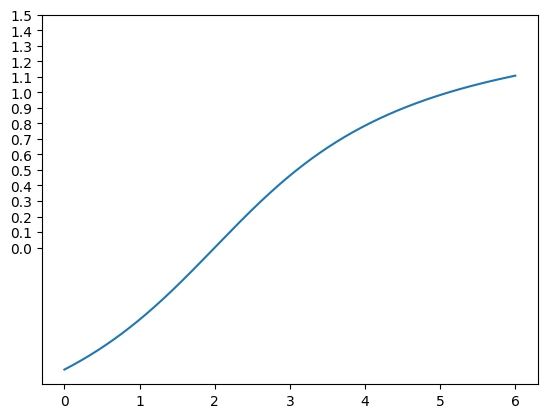

In [187]:
M=np.arange(0,6,1)
I=np.arange(0,6.01,0.01)
y=0.5
x=-0.5
d=0.25
# delta_theta = np.atan((-d*y)/(y**2+(x+M*d)*(x+(M+1)*d)))
theta = np.atan((x+I*d)/y)
fig,ax = plt.subplots()
# ax.plot(M,delta_theta)
ax.plot(I,theta)
ax.set_yticks(np.arange(0,1.6,0.1))
fig.show()

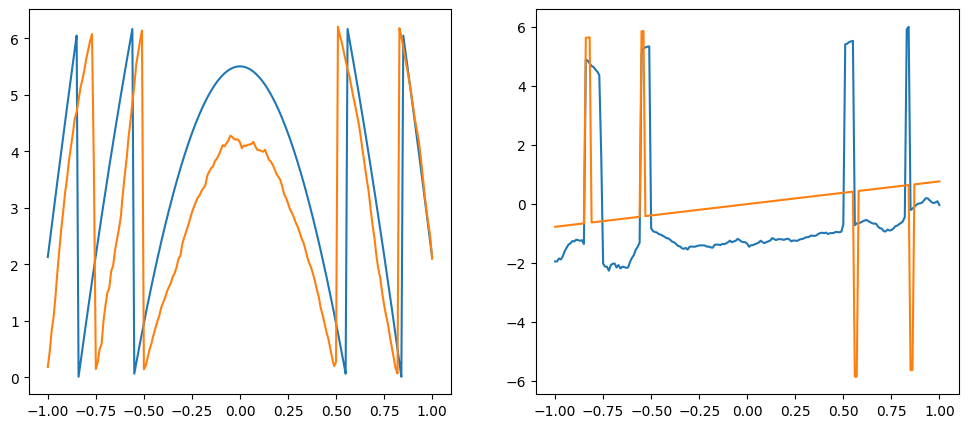

In [188]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
axes[0].plot(x_list, actual_phases)
axes[0].plot(x_list, phases.mean(axis=0))
axes[1].plot(x_list, phases.mean(axis=0)-actual_phases)
axes[1].plot(x_list, actual_phases_with_rotation-actual_phases)

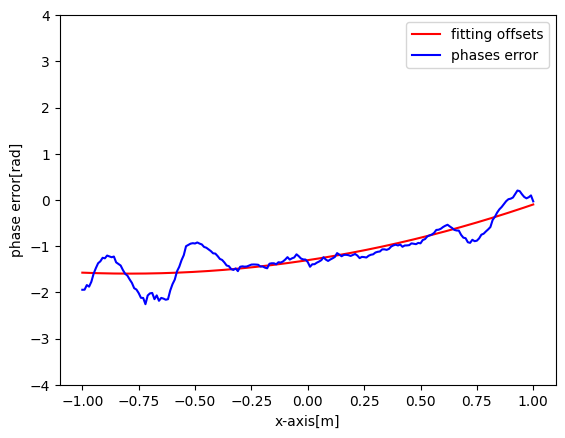

In [189]:
unwrapped_phases = np.unwrap(phases, axis=1)
# unwrapped_phases = signal.savgol_filter(x=unwrapped_phases, window_length=100, polyorder=2, axis=1)
phases = unwrapped_phases % (2*np.pi)
unwrapped_actual_phases = np.unwrap(actual_phases)
phases_mean_error = unwrapped_phases.mean(axis=0) - unwrapped_actual_phases
# phases_mean_error = unwrapped_phases.mean(axis=0) - unwrapped_actual_phases
phase_offsets = get_phase_offsets(phases,x_list,y=1.0)

fig,ax = plt.subplots()
# ax.plot(x_list, phases_mean_error)
ax.plot(x_list, phase_offsets, c="r", label="fitting offsets")
ax.plot(x_list, phases_mean_error, c="b", label="phases error")
ax.set_yticks(np.arange(-4,5,1))
ax.set_ylabel("phase error[rad]")
ax.set_xlabel("x-axis[m]")
ax.legend()
plt.show()

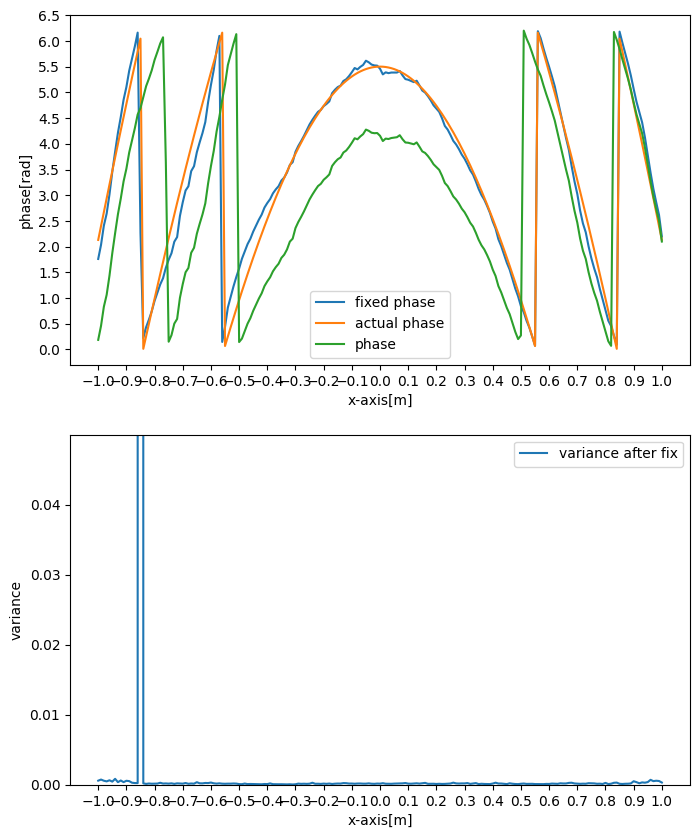

In [190]:
fixed_phase = get_fixed_phase(phase=phases, x_list=x_list, y=1)
fixed_phase_var = np.var(fixed_phase, axis=0)
fixed_phase_mean = fixed_phase.mean(axis=0)

fig, ax = plt.subplots(2,1,figsize=(8,10))
ax[0].plot(x_list, fixed_phase_mean, label="fixed phase")
ax[0].plot(x_list, actual_phases, label="actual phase")
ax[0].plot(x_list, phases.mean(axis=0), label="phase")
ax[0].set_yticks(np.arange(0,7.0,0.5))
ax[0].set_ylabel("phase[rad]")
ax[0].set_xticks(np.arange(-1.0,1.1,0.1))
ax[0].set_xlabel("x-axis[m]")
ax[0].legend()
ax[1].plot(x_list, fixed_phase_var, label="variance after fix")
ax[1].set_yticks(np.arange(0.0,0.05,0.01))
ax[1].set_ylim(0,0.05)
ax[1].set_ylabel("variance")
ax[1].set_xticks(np.arange(-1.0,1.1,0.1))
ax[1].set_xlabel("x-axis[m]")
ax[1].legend()
plt.show()

In [191]:
tag_population = 4
tags_space = 0.1
initial_value={"x":0,"y":1}
sample_count = 100

In [192]:
error_list = np.array([])
x_value = np.array([])
y_value = np.array([])

for i in np.arange(0, 151, 1):
    f = np.zeros(x_list.shape[0], dtype=bool)
    columns = i+10*np.arange(0,tag_population,1)
    f[columns] = True
    target_phases = fixed_phase[:,f]

    nfpo = NFPO(
        sample_count=sample_count,
        tags_space=tags_space,
        phases=target_phases,
        tag_population=tag_population,
        wave_length=wave_length,
        tag_location={"x":x_list[i],"y":1.0},
        initial_value=initial_value,
        x_err_range=1.0,
        y_err_range=1.0
    )

    result = nfpo.solve()
    error = sqrt((result["values"]["x"]-(i*0.01-1.0))**2+(result["values"]["y"]-1.0)**2)
    x_value  = np.append(x_value, result["values"]["x"])
    y_value  = np.append(y_value, result["values"]["y"])
    error_list=np.append(error_list,error)
value = np.array([x_value, y_value])

AttributeError: 'ConcreteModel' object has no attribute 'theta'

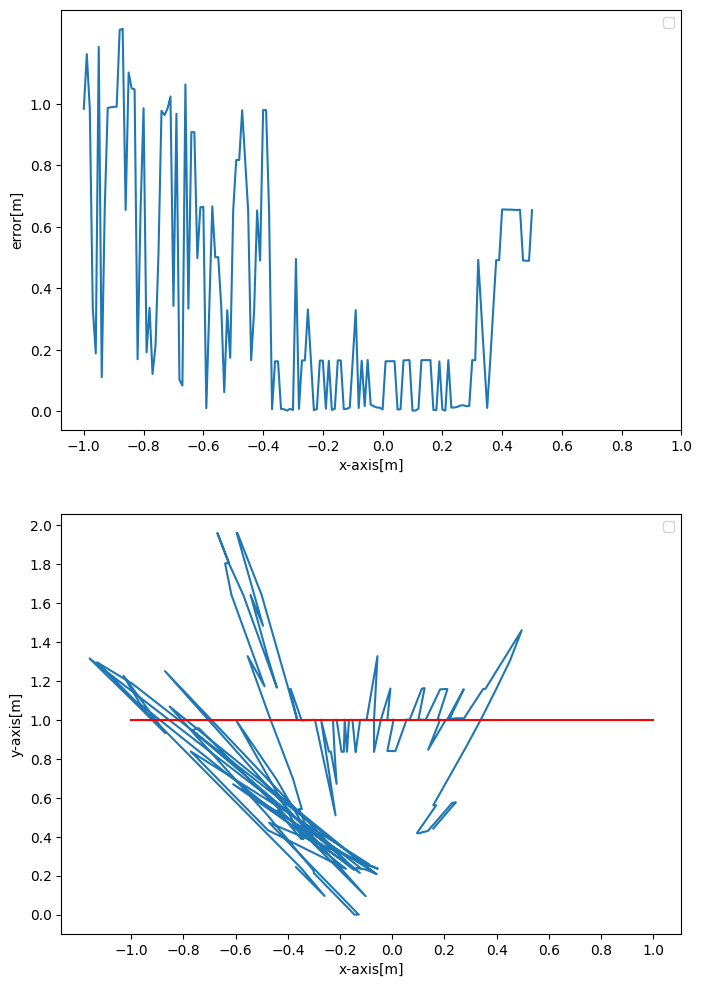

In [9]:
fig,axes = plt.subplots(2,1, figsize=(8,12))

axes[0].plot(x_list[0:151],error_list)
axes[0].set_ylabel("error[m]")
axes[0].set_yticks(np.arange(0,1.1,0.2))
axes[0].set_xlabel("x-axis[m]")
axes[0].set_xticks(np.arange(-1.0,1.1,0.2))
axes[0].legend()

axes[1].plot(x_value,y_value)
axes[1].plot(x_list,y_list, c="r")
axes[1].set_ylabel("y-axis[m]")
axes[1].set_xlabel("x-axis[m]")
axes[1].set_yticks(np.arange(0,2.2,0.2))
axes[1].set_xticks(np.arange(-1.0,1.1,0.2))
axes[1].legend()